### Setup and Initialization
This section imports the necessary libraries and prepares the environment for generating 3D views from a single input image.

In [1]:
!rm -rf sample_data
!rm -rf tmp

!pip install -U pip

# # Ensure Ninja is installed
# !conda install Ninja

# # Install the correct version of CUDA
# !conda install cuda -c nvidia/label/cuda-12.1.0

# Install PyTorch and xformers

# You may need to install another xformers version if you use a different PyTorch version
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121
!pip install xformers==0.0.22.post7

# # For Linux users: Install Triton
# !pip install triton
!pip install transformers datasets

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1+cu121
    Uninstalling torch-2.3.1+cu121:
      Successfully uninstalled torch-2.3.1+cu121
  Attempting uninstall: torchvision
    Found existing

#Clone the InstantMesh repo into Colab

with adding the requirements to work on

In [2]:
%cd /content
!GIT_LFS_SKIP_SMUDGE=1 git clone -b dev https://github.com/camenduru/InstantMesh
%cd /content/InstantMesh

# Install other requirements
!pip install -r /content/InstantMesh/requirements.txt
!pip install pytorch-lightning==2.1.2 gradio==3.50.2 einops omegaconf torchmetrics webdataset accelerate tensorboard
!pip install PyMCubes trimesh rembg transformers diffusers==0.20.2 bitsandbytes imageio[ffmpeg] xatlas plyfile
!pip install git+https://github.com/NVlabs/nvdiffrast jax==0.4.19 jaxlib==0.4.19 ninja

/content
fatal: destination path 'InstantMesh' already exists and is not an empty directory.
/content/InstantMesh
  Cloning https://github.com/NVlabs/nvdiffrast/ to /tmp/pip-req-build-3d34v75z
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast/ /tmp/pip-req-build-3d34v75z
  Resolved https://github.com/NVlabs/nvdiffrast/ to commit c5caf7bdb8a2448acc491a9faa47753972edd380
  Preparing metadata (setup.py) ... done
  Using cached pytorch_lightning-2.1.2-py3-none-any.whl.metadata (21 kB)
  Using cached gradio-4.26.0-py3-none-any.whl.metadata (15 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached torchmetrics-1.4.1-py3-none-any.whl.metadata (20 kB)
  Using cached webdataset-0.2.96-py3-none-any.whl.metadata (12 kB)
  Using cached PyMCubes-0.1.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (868 bytes)
  Using cached trimesh-4.4.6-py3-none-any.whl.metadata (18 kB)
  Using cached rembg-2.0.58-py3-non

  Using cached PyMCubes-0.1.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (868 bytes)
  Using cached trimesh-4.4.6-py3-none-any.whl.metadata (18 kB)
  Using cached rembg-2.0.58-py3-none-any.whl.metadata (16 kB)
  Using cached diffusers-0.20.2.tar.gz (989 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached bitsandbytes-0.43.3-py3-none-manylinux_2_24_x86_64.whl.metadata (3.5 kB)
  Using cached xatlas-0.0.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached plyfile-1.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached onnxruntime-1.19.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.3 kB)
  Using cached PyMatting-1.1.12-py3-none-any.whl.metadata (7.4 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
Usi

#Setup and Import Libraries to run the code

In [3]:
%cd /content/InstantMesh

import torch
model = None
torch.cuda.empty_cache()

import numpy as np
import rembg
from PIL import Image
from pytorch_lightning import seed_everything
from einops import rearrange
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler
from huggingface_hub import hf_hub_download
from src.utils.infer_util import remove_background, resize_foreground

/content/InstantMesh


### Load Pre-trained Diffusion Model
Here, we load a pre-trained diffusion model from the Hugging Face repository. This model is designed to generate multiple views from a single input image. The model is loaded onto a CUDA-enabled device (GPU) for efficient processing.

In [4]:
pipeline = DiffusionPipeline.from_pretrained("sudo-ai/zero123plus-v1.2", custom_pipeline="zero123plus",torch_dtype=torch.float16,)
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config, timestep_spacing='trailing')
unet_ckpt_path = hf_hub_download(repo_id="TencentARC/InstantMesh", filename="diffusion_pytorch_model.bin", repo_type="model")
state_dict = torch.load(unet_ckpt_path, map_location='cpu')
pipeline.unet.load_state_dict(state_dict, strict=True)
# modified to be able to work on cpu
device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
pipeline = pipeline.to(device)
seed_everything(0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/2.63k [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/708 [00:00<?, ?B/s]

(…)e_extractor_vae/preprocessor_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)_extractor_clip/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/391 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

vision_encoder/config.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

The config attributes {'dropout': 0.0, 'reverse_transformer_layers_per_block': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

INFO:lightning_fabric.utilities.seed:Seed set to 0


0

#Preprocessing the Input Image
This section handles the preprocessing of the input image, including optional background removal.

In [5]:
def preprocess(input_image, do_remove_background):
    rembg_session = rembg.new_session() if do_remove_background else None
    if do_remove_background:
        input_image = remove_background(input_image, rembg_session)
        input_image = resize_foreground(input_image, 0.85)
    return input_image

#Generate Multi-View Images
This section generates multi-view images using the processed input image.

In [6]:
def generate_mvs(input_image, sample_steps, sample_seed):
    seed_everything(sample_seed)
    generator = torch.Generator(device=device)
    z123_image = pipeline(
        input_image,
        num_inference_steps=sample_steps,
        generator=generator,
    ).images[0]
    show_image = np.asarray(z123_image, dtype=np.uint8)
    show_image = torch.from_numpy(show_image)     # (960, 640, 3)
    show_image = rearrange(show_image, '(n h) (m w) c -> (n m) h w c', n=3, m=2)
    show_image = rearrange(show_image, '(n m) h w c -> (n h) (m w) c', n=2, m=3)
    show_image = Image.fromarray(show_image.numpy())
    return z123_image, show_image

#try to load differnet images to run the model with it

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

#Load Input Image and Execute
This part loads the input image, processes it


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 163GB/s]


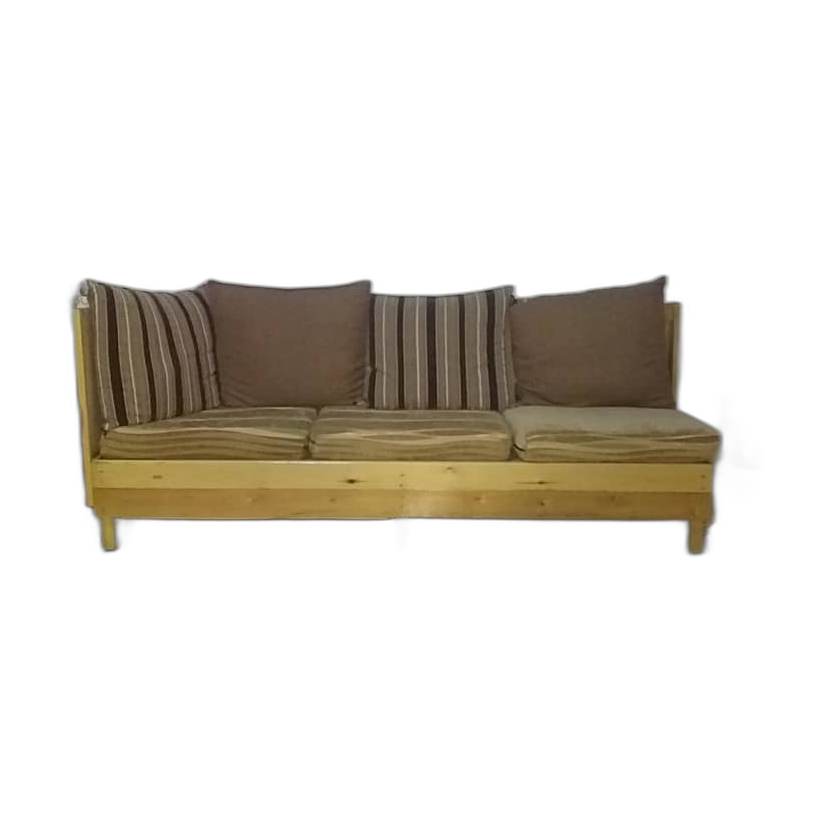

In [8]:
input_image_path = '/content/sooofa.jpg' #@param {type:"string"}
input_image = Image.open(input_image_path)
processed_image = preprocess(input_image, True)
processed_image

#Make multi views form image

In [9]:
!pip install diffusers==0.19.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.20.2
    Uninstalling diffusers-0.20.2:
      Successfully uninstalled diffusers-0.20.2


In [10]:
!pip install diffusers

In [11]:
import torch
from diffusers import UNet2DConditionModel, EulerAncestralDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import hf_hub_download

# Set device and dtype
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Load the UNet model architecture
unet_model = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="unet",
    torch_dtype=dtype,
).to(device)

# Load the model weights
unet_ckpt_path = hf_hub_download(repo_id="TencentARC/InstantMesh", filename="diffusion_pytorch_model.bin", repo_type="model")
state_dict = torch.load(unet_ckpt_path, map_location='cpu')
# unet_model.load_state_dict(state_dict)

# Load the scheduler
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="scheduler",
)

# Now you can use the `unet_model` and `scheduler` as needed.
# The code for image generation would need to be adapted to use this model and scheduler manually.

# Example setup (you'll need to adapt your image generation code accordingly):
def generate_image(input_image, sample_steps, sample_seed):
    generator = torch.Generator(device=device).manual_seed(sample_seed)

    # Dummy input for UNet model (you'll need to properly prepare your inputs based on your use case)
    latents = torch.randn((1, unet_model.in_channels, 64, 64), device=device, dtype=dtype)

    for step in range(sample_steps):
        noise_pred = unet_model(latents, timestep=step, encoder_hidden_states=None).sample
        latents = scheduler.step(noise_pred, step, latents, generator=generator).prev_sample

    # Post-process and convert latents to images
    # You'll need to add your own image post-processing logic here

    return latents

# Assuming 'input_image' is your preprocessed input
output_latents = generate_image(input_image=None, sample_steps=72, sample_seed=2500)

# Convert latents to PIL image
output_image = latents_to_image(output_latents)
output_image.save('/content/InstantMesh/new_images.png')


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

<ipython-input-11-e4d491ec9f4f>:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet_model.in_channels, 64, 64), device=device, dtype=dtype)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4096x320 and 768x320)

In [ ]:
import torch
from PIL import Image
import numpy as np
from huggingface_hub import hf_hub_download
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
from pytorch_lightning import seed_everything

# Set device and dtype
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Initialize the stable diffusion pipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    "TencentARC/InstantMesh",
    torch_dtype=dtype,
)

pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to(device)

# Load the model weights
unet_ckpt_path = hf_hub_download(repo_id="TencentARC/InstantMesh", filename="diffusion_pytorch_model.bin", repo_type="model")
state_dict = torch.load(unet_ckpt_path, map_location='cpu')
pipeline.unet.load_state_dict(state_dict, strict=False)
pipeline = pipeline.to(device)  # Move the pipeline to the correct device

# Set a seed for reproducibility
seed_everything(0)

# Define preprocessing function
def preprocess(input_image, do_remove_background=False):
    if do_remove_background:
        rembg_session = rembg.new_session()
        input_image = remove_background(input_image, rembg_session)
        input_image = resize_foreground(input_image, 0.85)
    return input_image

# Define MVS generation function
def generate_mvs(input_image, sample_steps, sample_seed):
    seed_everything(sample_seed)
    generator = torch.Generator(device=device).manual_seed(sample_seed)

    # Generate images
    result = pipeline(
        input_image,
        num_inference_steps=sample_steps,
        generator=generator,
    )
    z123_image = result.images[0]

    # Process the output image for visualization
    show_image = np.asarray(z123_image, dtype=np.uint8)
    show_image = Image.fromarray(show_image)  # Convert to PIL image
    return z123_image, show_image

# Assuming 'processed_image_pil' is your input image in PIL format
processed_image_pil = processed_image_pil.convert("RGB")  # Ensure the image is in RGB format

# Generate MVS images using the PIL image directly
mv_images, mv_show_images = generate_mvs(processed_image_pil, 72, 2500)

# Save the output image
mv_images.save('/content/InstantMesh/new_images.png')

# Display the output image
mv_show_images.show()


In [ ]:
# Assuming 'processed_image_pil' is your input image in PIL format
processed_image_pil = processed_image_pil.convert("RGB")  # Ensure the image is in RGB format

# Generate MVS images using the PIL image directly
mv_images, mv_show_images = generate_mvs(processed_image_pil, 72, 2500)

# Save the output image
mv_images.save('/content/InstantMesh/new_images.png')

# Display the output image
mv_show_images.show()

In [ ]:
mv_images, mv_show_images = generate_mvs(processed_image, 72, 2500)
mv_images.save('/content/InstantMesh/new_images.png')
mv_show_images

In [ ]:
import torch
from torchvision import transforms
from PIL import Image # Import the PIL Image module

# Assuming 'processed_image' is your input image tensor
# Convert the tensor to float32
processed_image_tensor = processed_image.float()

# Convert the tensor back to a PIL Image (if you need to visualize it)
processed_image_pil = transforms.ToPILImage()(processed_image_tensor)

# Ensure the image is in RGB format
processed_image_pil = processed_image_pil.convert("RGB")

# Pass the PIL Image directly to generate_mvs
mv_images, mv_show_images = generate_mvs(processed_image_pil, 72, 2500)

# Save the output image
mv_images.save('/content/InstantMesh/new_images.png')

# Display the generated image (if necessary)
mv_show_images.show()


In [ ]:
# Assuming 'processed_image_pil' is your PIL Image

# Convert to tensor and ensure it's float32
processed_image_tensor = transforms.ToTensor()(processed_image_pil).float()

# Check if the tensor is in float16 (half-precision)
if processed_image_tensor.dtype == torch.float16:
    processed_image_tensor = processed_image_tensor.to(torch.float32)

# Pass the tensor to generate_mvs
mv_images, mv_show_images = generate_mvs(processed_image_tensor, 72, 2500)

# Save the output image
mv_images.save('/content/InstantMesh/new_images.png')

# Display the generated image
mv_show_images.show()


### Preprocess Input Image
In this section, the input image is preprocessed, including optional background removal and resizing. This step is crucial to ensure the input image is in the correct format for the model.

In [ ]:
%cd /content/InstantMesh

import torch
pipeline = None
torch.cuda.empty_cache()

import os
from torchvision.transforms import v2
from huggingface_hub import hf_hub_download
from omegaconf import OmegaConf
from PIL import Image
import numpy as np
from einops import rearrange, repeat
import tempfile
from tqdm import tqdm
import imageio
from src.utils.train_util import instantiate_from_config
from src.utils.camera_util import (FOV_to_intrinsics, get_zero123plus_input_cameras,get_circular_camera_poses,)
from src.utils.mesh_util import save_obj, save_obj_with_mtl


# Choosing the pre-trained model for the image
# to change it
you have to change config path and the model_ckpt_path


In [ ]:
config_path = 'configs/instant-mesh-base.yaml'
config = OmegaConf.load(config_path)
config_name = os.path.basename(config_path).replace('.yaml', '')
model_config = config.model_config
infer_config = config.infer_config
model_ckpt_path = hf_hub_download(repo_id="TencentARC/InstantMesh", filename="instant_mesh_base.ckpt", repo_type="model")
model = instantiate_from_config(model_config)
state_dict = torch.load(model_ckpt_path, map_location='cpu')['state_dict']
state_dict = {k[14:]: v for k, v in state_dict.items() if k.startswith('lrm_generator.') and 'source_camera' not in k}
model.load_state_dict(state_dict, strict=True)
device = torch.device('cuda')
model = model.to(device)
IS_FLEXICUBES = True if config_name.startswith('instant-mesh') else False
if IS_FLEXICUBES:
    model.init_flexicubes_geometry(device, fovy=30.0)
model = model.eval()

In [ ]:
def images_to_video(images, output_path, fps=30):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    frames = []
    for i in range(images.shape[0]):
        frame = (images[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8).clip(0, 255)
        assert frame.shape[0] == images.shape[2] and frame.shape[1] == images.shape[3], \
            f"Frame shape mismatch: {frame.shape} vs {images.shape}"
        assert frame.min() >= 0 and frame.max() <= 255, \
            f"Frame value out of range: {frame.min()} ~ {frame.max()}"
        frames.append(frame)
    imageio.mimwrite(output_path, np.stack(frames), fps=fps, codec='h264')

In [ ]:
def get_render_cameras(batch_size=1, M=120, radius=2.5, elevation=10.0, is_flexicubes=False):
    c2ws = get_circular_camera_poses(M=M, radius=radius, elevation=elevation)
    if is_flexicubes:
        cameras = torch.linalg.inv(c2ws)
        cameras = cameras.unsqueeze(0).repeat(batch_size, 1, 1, 1)
    else:
        extrinsics = c2ws.flatten(-2)
        intrinsics = FOV_to_intrinsics(30.0).unsqueeze(0).repeat(M, 1, 1).float().flatten(-2)
        cameras = torch.cat([extrinsics, intrinsics], dim=-1)
        cameras = cameras.unsqueeze(0).repeat(batch_size, 1, 1)
    return cameras

In [ ]:
def make_mesh(mesh_fpath, planes):
    mesh_basename = os.path.basename(mesh_fpath).split('.')[0]
    mesh_dirname = os.path.dirname(mesh_fpath)
    mesh_vis_fpath = os.path.join(mesh_dirname, f"{mesh_basename}.glb")
    with torch.no_grad():
        mesh_out = model.extract_mesh(planes, use_texture_map=True, **infer_config,)
        vertices, faces, uvs, mesh_tex_idx, tex_map = mesh_out
        # vertices = vertices[:, [1, 2, 0]]
        # vertices[:, -1] *= -1
        # faces = faces[:, [2, 1, 0]]
        save_obj_with_mtl(
            vertices.data.cpu().numpy(),
            uvs.data.cpu().numpy(),
            faces.data.cpu().numpy(),
            mesh_tex_idx.data.cpu().numpy(),
            tex_map.permute(1, 2, 0).data.cpu().numpy(),
            mesh_fpath,
        )
        print(f"Mesh with texmap saved to {mesh_fpath}")
        # vertices, faces, vertex_colors = mesh_out
        # vertices = vertices[:, [1, 2, 0]]
        # vertices[:, -1] *= -1
        # faces = faces[:, [2, 1, 0]]
        # save_obj(vertices, faces, vertex_colors, mesh_fpath)
        # print(f"Mesh saved to {mesh_fpath}")
    return mesh_fpath

#Modified when CUDA GPU RAM TIMES OUT


In [ ]:
def make3d(images):
    images = np.asarray(images, dtype=np.float32) / 255.0
    images = torch.from_numpy(images).permute(2, 0, 1).contiguous().float()     # (3, 960, 640)
    images = rearrange(images, 'c (n h) (m w) -> (n m) c h w', n=3, m=2)        # (6, 3, 320, 320)
    input_cameras = get_zero123plus_input_cameras(batch_size=1, radius=4.0).to(device)
    render_cameras = get_render_cameras(
        batch_size=1, radius=4.5, elevation=20.0, is_flexicubes=IS_FLEXICUBES).to(device)
    images = images.unsqueeze(0).to(device)
    images = v2.functional.resize(images, (320, 320), interpolation=3, antialias=True).clamp(0, 1)
    directory = '/content/tmp'
    if not os.path.exists(directory):
        os.makedirs(directory)
    tempfile.tempdir = directory
    mesh_fpath = tempfile.NamedTemporaryFile(suffix=f".obj", delete=False).name
    print(mesh_fpath)
    mesh_basename = os.path.basename(mesh_fpath).split('.')[0]
    mesh_dirname = os.path.dirname(mesh_fpath)
    video_fpath = os.path.join(mesh_dirname, f"{mesh_basename}.mp4")
    with torch.no_grad():
        planes = model.forward_planes(images, input_cameras)
        chunk_size = 20 if IS_FLEXICUBES else 1
        render_size = 384
        frames = []
        for i in tqdm(range(0, render_cameras.shape[1], chunk_size)):
            if IS_FLEXICUBES:
                frame = model.forward_geometry(planes, render_cameras[:, i:i+chunk_size], render_size=render_size,)['img']
            else:
                frame = model.synthesizer(planes, cameras=render_cameras[:, i:i+chunk_size],render_size=render_size,)['images_rgb']
            frames.append(frame)
            # Free up memory
            del frame
            gc.collect()
            torch.cuda.empty_cache()
        frames = torch.cat(frames, dim=1)
        images_to_video(frames[0], video_fpath, fps=30,)
        print(f"Video saved to {video_fpath}")
    mesh_fpath = make_mesh(mesh_fpath, planes)
    return video_fpath, mesh_fpath

In [ ]:
import gc
# def make3d(images):
#     # Normalize and prepare the input image
#     images = np.asarray(images, dtype=np.float32) / 255.0
#     images = torch.from_numpy(images).permute(2, 0, 1).contiguous().float()  # (3, 960, 640)
#     images = rearrange(images, 'c (n h) (m w) -> (n m) c h w', n=3, m=2)     # (6, 3, 320, 320)

#     # Prepare camera settings
#     input_cameras = get_zero123plus_input_cameras(batch_size=1, radius=4.0).to(device)
#     render_cameras = get_render_cameras(batch_size=1, radius=4.5, elevation=20.0, is_flexicubes=IS_FLEXICUBES).to(device)

#     # Resize images to reduce memory usage
#     images = images.unsqueeze(0).to(device)
#     images = v2.functional.resize(images, (128, 128), interpolation=3, antialias=True).clamp(0, 1)  # Reduced resolution

#     # Set up temporary directory and file paths
#     directory = '/content/tmp'
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#     tempfile.tempdir = directory
#     mesh_fpath = tempfile.NamedTemporaryFile(suffix=".obj", delete=False).name
#     mesh_basename = os.path.basename(mesh_fpath).split('.')[0]
#     mesh_dirname = os.path.dirname(mesh_fpath)
#     video_fpath = os.path.join(mesh_dirname, f"{mesh_basename}.mp4")

#     # Generate the 3D model and video
#     with torch.no_grad():
#         planes = model.forward_planes(images, input_cameras)
#         chunk_size = 10  # Process render cameras one by one
#         render_size = 64  # Further reduce render size
#         frames = []

#         for i in tqdm(range(0, render_cameras.shape[1], chunk_size)):
#             if IS_FLEXICUBES:
#                 frame = model.forward_geometry(planes, render_cameras[:, i:i+chunk_size], render_size=render_size)['img']
#             else:
#                 frame = model.synthesizer(planes, cameras=render_cameras[:, i:i+chunk_size], render_size=render_size)['images_rgb']
#             frames.append(frame.cpu())  # Move frame to CPU immediately

#             # Free up memory
#             del frame
#             gc.collect()
#             torch.cuda.empty_cache()

#         frames = torch.cat(frames, dim=1).to(device)  # Move concatenated frames to GPU for video creation
#         images_to_video(frames[0], video_fpath, fps=30)
#         print(f"Video saved to {video_fpath}")

#     # Generate the mesh
#     mesh_fpath = make_mesh(mesh_fpath, planes)
#     return video_fpath, mesh_fpath

#Generate the Model and video
the generations produce 3 items:


1.   obj file
2.   mtl file
3.   png image that conatain the texture of the object model




In [ ]:
mv_images = Image.open('/content/InstantMesh/new_images.png')
output_video, output_model_obj = make3d(mv_images)
# !cp -f {output_video} /content/InstantMesh/output_video.mp4
!cp -f {output_model_obj} /content/InstantMesh/output_model.obj
from IPython.display import Video
Video(output_video, embed=True)